# Teste

In [ ]:
# Importação das bibliotecas
import xml.etree.ElementTree as ET
import os, sys, json, shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import locale
import cv2
from glob import glob
from IPython.display import display
from google.colab import userdata, drive
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Caminho completo do diretório .kaggle
kaggle_folder = os.path.expanduser('~/.kaggle')

# Cria o diretório se não existir
os.makedirs(kaggle_folder, exist_ok=True)

# Caminho completo do arquivo JSON de autenticação
kaggle_auth_file = os.path.join(kaggle_folder, 'kaggle.json')

# Cria o arquivo JSON de autenticação
with open(kaggle_auth_file, 'w') as jsonFile:
    json.dump({
        "username": userdata.get('kaggle_usr'),
        "key": userdata.get('kaggle_key')
    }, jsonFile)

# Define as permissões do arquivo
os.chmod(kaggle_auth_file, 0o600)

print("Arquivo JSON de autenticação criado com sucesso em:", kaggle_auth_file)

Arquivo JSON de autenticação criado com sucesso em: /root/.kaggle/kaggle.json


In [ ]:
# Instalar o pacote kaggle
!pip install kaggle

In [ ]:
# Excluir diretório existente
if os.path.exists("/content/datasets/"):
    shutil.rmtree("/content/datasets/")

# Cria o diretório se não existir
os.makedirs("/content/datasets/raw/", exist_ok=True)

# Fazer download do dataset
!kaggle datasets download -d kaiquanmah/tobacco800-with-ground-truth --path /content/datasets/raw --force

Dataset URL: https://www.kaggle.com/datasets/kaiquanmah/tobacco800-with-ground-truth
License(s): unknown
 95% 31.0M/32.8M [00:02<00:00, 19.1MB/s]
100% 32.8M/32.8M [00:03<00:00, 11.3MB/s]


In [ ]:
!unzip /content/datasets/raw/tobacco800-with-ground-truth.zip -d /content/datasets/raw/tobacco800-with-ground-truth/

Archive:  /content/datasets/raw/tobacco800-with-ground-truth.zip
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/Overview of Tobacco800 Groundtruth_v2.0.txt  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aah97e00-page02_1.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aah97e00-page02_2.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aam09c00.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aao54e00_1.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/a

In [ ]:
# Define os caminhos para acessar o dataset e os arquivos associados à fonte de dados.
source_dataset_path = '/content/datasets/raw/tobacco800-with-ground-truth'
source_images_path = f'{source_dataset_path}/Tobacco800_SinglePage/Tobacco800_SinglePage/SinglePageTIF'
source_annotation_files_path = f'{source_dataset_path}/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0'

# Lista em ordem alfabética todos os arquivos XML dentro do diretório especificado
annotation_files = sorted(glob(f'{source_annotation_files_path}/*.xml'))

# Inicializa uma lista para armazenar informações extraídas dos arquivos XML
extracted_data = []

# Coletar todas as categorias de todos os nós para treinamento do LabelEncoder
all_categories = []
for file_path in annotation_files:
    root_element = ET.parse(file_path).getroot()
    for node in root_element[0][0]:
        all_categories.append(node.attrib.get('gedi_type'))

# Treinar o LabelEncoder com todas as categorias coletadas
label_encoder = LabelEncoder()
label_encoder.fit(all_categories)

# Processar cada arquivo XML
for file_path in annotation_files:
    root_element = ET.parse(file_path).getroot()
    file_name = root_element[0].attrib.get('src')
    page_height = root_element[0][0].attrib.get('height')
    page_width = root_element[0][0].attrib.get('width')

    # Extrair informações de cada nó na página
    for node in root_element[0][0]:
        id = node.attrib.get('id')
        gedi_type = node.attrib.get('gedi_type')
        labels = label_encoder.transform([gedi_type])

        x, y = node.attrib.get('col'), node.attrib.get('row')
        w, h = node.attrib.get('width'), node.attrib.get('height')

        if gedi_type == 'DLSignature':
            author = node.attrib.get('AuthorID')
            is_overlapped = node.attrib.get('Overlapped')
        else:
            author, is_overlapped = ('NA', 'NA')

        # Construir linha com os dados essenciais
        row = [file_name, gedi_type, labels, x, y, w, h, page_width, page_height, author, is_overlapped, id]
        extracted_data.append(row)

# Criar um DataFrame com os dados extraídos
xml_extracted_data = pd.DataFrame(extracted_data, columns=[
    'file_name', 'gedi_type', 'labels', 'x', 'y', 'w', 'h',
    'page_width', 'page_height', 'author', 'is_overlapped', 'id'
])
xml_extracted_data.head(10)

,file_name,gedi_type,labels,x,y,w,h,page_width,page_height,author,is_overlapped,id
0,aah97e00-page02_1.tif,DLLogo,[0],1074,18,374,219,2560,3296,NA,NA,None
1,aah97e00-page02_2.tif,DLSignature,[1],1409,793,659,361,2560,3296,"Boder, J.B.",Yes,None
2,aam09c00.tif,DLSignature,[1],821,1422,757,183,1728,2292,"Koplow, M.G.",Yes,None
3,aao54e00_2.tif,DLSignature,[1],1514,708,627,206,2560,3296,"Landry, J.T.",Yes,None
4,abm69c00.tif,DLSignature,[1],667,1279,617,110,1728,2292,"Feldman, J.D.",Yes,None
5,acr64d00.tif,DLSignature,[1],886,1801,463,181,1728,2292,"Boffa, J.R.",Yes,None
6,adh36e00-page2_1.tif,DLLogo,[0],1181,18,359,219,2560,3245,NA,NA,None
7,adh36e00-page2_2.tif,DLSignature,[1],1232,2399,896,431,2560,3246,"Krivisky, B.M.",Yes,None
8,adh36e00_1.tif,DLLogo,[0],1187,18,347,219,2560,3245,NA,NA,None
9,adh36e00_2.tif,DLSignature,[1],1239,2403,889,434,2560,3246,"Krivisky, B.M.",Yes,None


In [ ]:
dataset_name = 'tobacco800'
target_dataset_path = f'/content/datasets/{dataset_name}'
target_resized_images_path = f'{target_dataset_path}/images/resized'

# Excluir diretório existente
if os.path.exists(target_resized_images_path):
    shutil.rmtree(target_resized_images_path)

# Cria o diretório se não existir
os.makedirs(target_resized_images_path, exist_ok=True)

In [ ]:
# Redimensionando as imagens para reduzir o tempo de treinamento
def resizing_extracted_data(data):
    resized_data = []

    for file, labels, x, y, w, h in zip(data.file_name, data.labels, map(int, data.x), map(int, data.y), map(int, data.w), map(int, data.h)):
        image_path = f'{source_images_path}/{file}'
        image = cv2.imread(image_path, 1)

        page_height, page_width = image.shape[:2]
        max_height = 640
        max_width = 480

        resize_factor = min(max_height / page_height, max_width / page_width)

        if resize_factor < 1:
            image = cv2.resize(image, None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_AREA)

        resized_file_name = f'{file[:-4]}.jpg'
        cv2.imwrite(f'{target_resized_images_path}/{resized_file_name}', image)

        # Salva novas dimensões da página
        resized_page_width, resized_page_height = int(page_width * resize_factor), int(page_height * resize_factor)

        # Calcula novas coordenadas x, y, w, h após redimensionamento
        resized_x, resized_y, resized_w, resized_h = int(x * resize_factor), int(y * resize_factor), int(w * resize_factor), int(h * resize_factor)

        row = [resized_file_name, labels, resized_x, resized_y, resized_w, resized_h, resized_page_width, resized_page_height]
        resized_data.append(row)
    return resized_data

resized_data = resizing_extracted_data(xml_extracted_data)

resized_data = pd.DataFrame(resized_data, columns=['file_name', 'labels', 'x', 'y', 'w', 'h', 'page_width', 'page_height'])
resized_data.head(10)

,file_name,labels,x,y,w,h,page_width,page_height
0,aah97e00-page02_1.jpg,[0],201,3,70,41,480,618
1,aah97e00-page02_2.jpg,[1],264,148,123,67,480,618
2,aam09c00.jpg,[1],228,395,210,50,480,636
3,aao54e00_2.jpg,[1],283,132,117,38,480,618
4,abm69c00.jpg,[1],185,355,171,30,480,636
5,acr64d00.jpg,[1],246,500,128,50,480,636
6,adh36e00-page2_1.jpg,[0],221,3,67,41,480,608
7,adh36e00-page2_2.jpg,[1],231,449,168,80,480,608
8,adh36e00_1.jpg,[0],222,3,65,41,480,608
9,adh36e00_2.jpg,[1],232,450,166,81,480,608


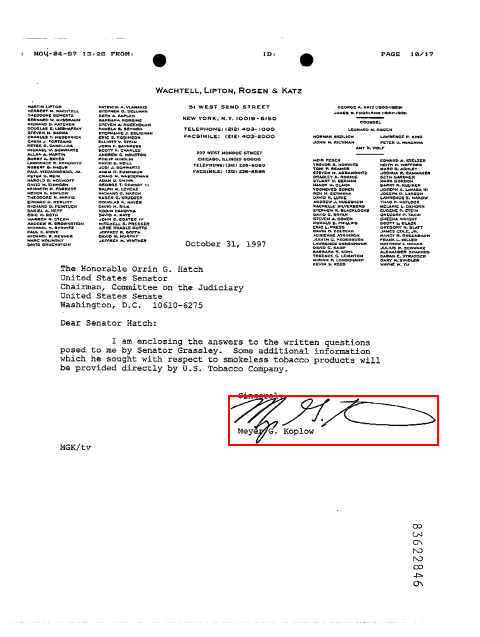

In [ ]:
# Teste do redimensionamento das imagens e suas respectivas anotações.
def draw_boxes_on_image(data):
    file, x, y, w, h = data.file_name, data.x, data.y, data.w, data.h
    image = Image.open(f'{target_resized_images_path}/{file}')
    draw = ImageDraw.Draw(image)
    draw.rectangle([(x, y), (x + w, y + h)], outline="red", width=2)
    display(image)
draw_boxes_on_image(resized_data.iloc[2])

In [ ]:
train_data, valid_data = train_test_split(resized_data, test_size=0.1, random_state=13, shuffle=True)
print(train_data.shape, valid_data.shape)

(1207, 8) (135, 8)


In [ ]:
target_val_images_path = f'{target_dataset_path}/images/val'
target_val_labels_path = f'{target_dataset_path}/labels/val'
target_train_images_path = f'{target_dataset_path}/images/train'
target_train_labels_path = f'{target_dataset_path}/labels/train'

# Excluir diretório existente
if os.path.exists(target_val_images_path):
    shutil.rmtree(target_val_images_path)

if os.path.exists(target_val_labels_path):
    shutil.rmtree(target_val_labels_path)

if os.path.exists(target_train_images_path):
    shutil.rmtree(target_train_images_path)

if os.path.exists(target_train_labels_path):
    shutil.rmtree(target_train_labels_path)

# Cria o diretório se não existir
os.makedirs(target_val_images_path, exist_ok=True)
os.makedirs(target_val_labels_path, exist_ok=True)
os.makedirs(target_train_images_path, exist_ok=True)
os.makedirs(target_train_labels_path, exist_ok=True)

In [ ]:
def yolo_format(data):
    x, y, w, h, page_width, page_height = data.x, data.y, data.w, data.h, data.page_width, data.page_height

    x_center = int(x + (w / 2))
    y_center = int(y + (h / 2))

    normalized_x = x_center / page_width
    normalized_y = y_center / page_height

    normalized_w = w / page_width
    normalized_h = h / page_height

    return [normalized_x, normalized_y, normalized_w, normalized_h]

def segregate_data(data, source_images_path, target_images_path, target_labels_path):
    # Obter nomes de arquivos únicos
    file_names = set(data['file_name'])

    for file_name in file_names:
        yolo_list = []

        # Filtrar linhas para o arquivo atual
        file_data = data[data['file_name'] == file_name]

        for _, row in file_data.iterrows():
            yolo_list.append([row.labels[0], *yolo_format(row)])

        # Converter yolo_list em array NumPy
        yolo_list = np.array(yolo_list)

        # Salvar os dados em arquivos TXT
        txt_file_name = os.path.join(target_labels_path, f'{file_name.split(".")[0]}.txt')
        np.savetxt(txt_file_name, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])

        # Copiar as imagens de origem para o destino
        source_images = os.path.join(source_images_path, file_name)
        target_images = os.path.join(target_images_path, file_name)
        shutil.copyfile(source_images, target_images)

segregate_data(train_data, target_resized_images_path, target_train_images_path, target_train_labels_path)
segregate_data(valid_data, target_resized_images_path, target_val_images_path, target_val_labels_path)

# Número de arquivos de imagem e rótulos nos diretórios de treinamento e validação
print("Número de imagens de treinamento:", len(os.listdir(target_train_images_path)))
print("Número de rótulos de treinamento:", len(os.listdir(target_train_labels_path)))
print("Número de imagens de validação:", len(os.listdir(target_val_images_path)))
print("Número de rótulos de validação:", len(os.listdir(target_val_labels_path)))

Número de imagens de treinamento: 807
Número de rótulos de treinamento: 807
Número de imagens de validação: 129
Número de rótulos de validação: 129


In [ ]:
try:
  shutil.rmtree(f'{target_val_images_path}/.ipynb_checkpoints')
except FileNotFoundError:
  pass
try:
  shutil.rmtree(f'{target_val_labels_path}/.ipynb_checkpoints')
except FileNotFoundError:
  pass
try:
  shutil.rmtree(f'{target_train_images_path}/.ipynb_checkpoints')
except FileNotFoundError:
  pass
try:
  shutil.rmtree(f'{target_train_labels_path}/.ipynb_checkpoints')
except FileNotFoundError:
  pass

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Não conectado a uma GPU.')
else:
  print(gpu_info)

Wed May  1 17:40:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   44C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.5 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 29.0/201.2 GB disk)


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

results = model.train(data='/content/datasets/tobacco800.yaml', task='detect', epochs=300, imgsz=640, patience=100)

100%|██████████| 6.23M/6.23M [00:00<00:00, 318MB/s]

Transferred 355/355 items from pretrained weights


Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/datasets/tobacco800.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

RuntimeError: Dataset '/content/datasets/tobacco800.yaml' error ❌ '/content/datasets/tobacco800.yaml' does not exist

In [ ]:
# return [normalized_x, normalized_y, normalized_w, normalized_h]
# <label> <x_center_norm> <y_center_norm> <width_norm> <height_norm>
# Teste do formato YOLO.
# image = Image.open('/content/datasets/tobacco800/images/train/aam09c00.jpg')
# draw = ImageDraw.Draw(image)
# draw.rectangle([(), ()], outline="red", width=2)
# display(image)